# This notebook is an example of how to generate a pulsar catalog, choose a signal, run an MCMC and compare with Fisher results

### - Start importing all libraries

In [1]:
# Global
import numpy as np

# Local
import examples_utils as eu
import fastPTA.utils as ut
import fastPTA.plotting_functions as pf

from fastPTA.priors import Priors
from fastPTA.signals import get_signal_model
from fastPTA.Fisher_code import compute_fisher
from fastPTA.MCMC_code import run_MCMC

### - Constants to be used in the analysis

In [2]:
# Total observation time in years
T_obs_yrs = 10.0  # 6.03

# Number of frequencies used in the analysis
n_frequencies = 30

# Number of pulsars in the analysis
n_pulsars = 50

# Specify the type of noise to be used in the analysis
which_experiment = eu.mockSKA10

# Set the label to specify the signal model
signal_label = "power_law"

# The analysis assumes a power law template, specify here the input parameters
log_amplitude = -7.1995  # log amplitude
tilt = 2.0  # Tilt

# Specify the true signal parameters
signal_parameters = np.array([log_amplitude, tilt])

# Choose some labels for the parameters, if not will use the standard labels
# for the signal model
parameter_labels = []

# Specify the priors for the signal parameters (should be a dictionary, the
# parameter names are the keys and the values are the dictionaries with the
# prior information) if not specfied here will build from fisher results
priors_dictionary = {}

# Number of points to generate for the Fisher
len_fisher_data = int(1e4)

# Name of the pulsar catalogue
outname = "pulsar_configurations/test_future.txt"

### - Some inputs for the MCMC

In [3]:
# Whether the MCMC should be rerun
rerun_MCMC = True

# Whether the MCMC data should be regenerated
regenerate_MCMC_data = True

# Whether to generate a data realization or take data at face value
realization = False

# Number of burnin steps for the MCMC
burnin_steps_default = 100

# Maximum number of iterations to get R close to 1
i_max_default = 100

# Accepted value for the Gellman-Rubin convergence criterion
R_convergence_default = 1e-1

# Criterion to be used for the convergence of the MCMC chains
R_criterion_default = "mean_squared"

# Number of MCMC steps in each iteration
MCMC_iteration_steps_default = 300

# Path to the MCMC_data
path_to_MCMC_data = "generated_data/MCMC_data_future.npz"

# Path to the MCMC chains
path_to_MCMC_chains = "generated_chains/MCMC_chains_future.npz"

### - Set the inputs for the Fisher and MCMC analysis

In [4]:
# Get the signal model
signal_model = get_signal_model(signal_label)

# Dictionary with the kwargs to generete the pulsar catalogs
generate_catalog_kwargs = {
    "n_pulsars": n_pulsars,
    "save_catalog": True,
    **which_experiment,
}

# Dictionary with the kwargs to generate noise and orf tensors
get_tensors_kwargs = {
    "add_curn": False,
    "regenerate_catalog": True,
    "path_to_pulsar_catalog": outname,
}

# Dictionary with the kwargs for the Fisher matrix
fisher_kwargs = {
    "T_obs_yrs": T_obs_yrs,
    "n_frequencies": n_frequencies,
    "signal_model": signal_model,
    "signal_parameters": signal_parameters,
}

# Dictionary with the kwargs for the MCMC
MCMC_kwargs = {
    "regenerate_MCMC_data": regenerate_MCMC_data,
    "realization": realization,
    "path_to_MCMC_data": path_to_MCMC_data,
    "path_to_MCMC_chains": path_to_MCMC_chains,
    "i_max": i_max_default,
    "R_convergence": R_convergence_default,
    "R_criterion": R_criterion_default,
    "burnin_steps": burnin_steps_default,
    "MCMC_iteration_steps": MCMC_iteration_steps_default,
}

### - Prepare the model to scan over

In [5]:
if "regenerate_catalog" in get_tensors_kwargs.keys():
    if get_tensors_kwargs["regenerate_catalog"]:
        rerun_MCMC = True

(
    frequency,
    signal_value,
    HD_functions_IJ,
    HD_coeffs,
    effective_noise,
    SNR,
    fisher,
) = compute_fisher(
    **fisher_kwargs,
    get_tensors_kwargs=get_tensors_kwargs,
    generate_catalog_kwargs=generate_catalog_kwargs,
)

covariance = ut.compute_inverse(fisher)
fisher_data = np.random.multivariate_normal(
    signal_parameters, covariance, size=len_fisher_data
)
errors = np.sqrt(np.diag(covariance))
print("Fisher errors", errors)

fisher_ranges = np.vstack(
    (signal_parameters - 5 * errors, signal_parameters + 5 * errors)
)

get_tensors_kwargs["regenerate_catalog"] = False

Fisher errors [0.0278207  0.06017251]


### - Prepare the priors

In [6]:
# If the priors dictionary is empty, build it from the Fisher results
if not priors_dictionary:
    parameter_names = signal_model.parameter_names
    for i in range(len(parameter_names)):

        priors_dictionary[parameter_names[i]] = {
            "uniform": {"loc": fisher_ranges[0, i], "scale": 10.0 * errors[i]}
        }

priors = Priors(priors_dictionary)

In [7]:
try:
    if rerun_MCMC:
        raise FileNotFoundError("Flag forces MCMC chains regeneration")

    MCMC_results = np.load(path_to_MCMC_chains)
    MCMC_data = MCMC_results["samples"]
    pdfs = MCMC_results["pdfs"]

except FileNotFoundError:
    MCMC_data, pdfs = run_MCMC(
        priors,
        **fisher_kwargs,
        **MCMC_kwargs,
        get_tensors_kwargs=get_tensors_kwargs,
    )



Regenerating MCMC data
- Data will use the expectation value

Initial run


100%|██████████| 100/100 [00:08<00:00, 12.31it/s]


Burn-in dropped, here starts the proper run


100%|██████████| 300/300 [00:23<00:00, 12.80it/s]


At this step R = 1.1035


100%|██████████| 300/300 [00:24<00:00, 12.09it/s]

At this step R = 1.0659
This took 57.2 seconds 

Storing as generated_chains/MCMC_chains_future.npz


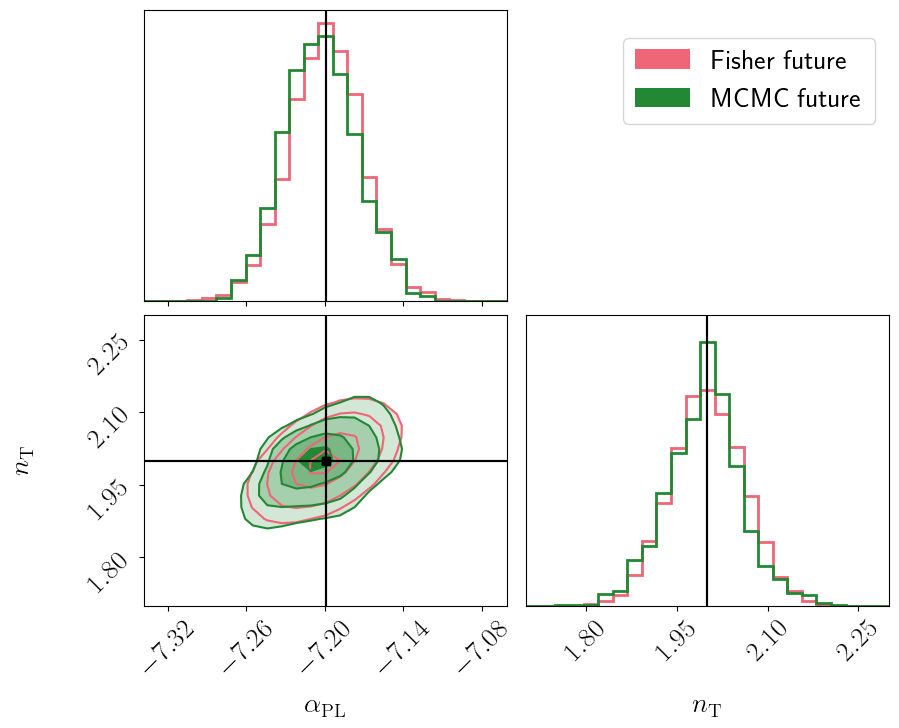

In [8]:
# Set the labels for the signal parameters
if not parameter_labels:
    parameter_labels = signal_model.parameter_labels

# Prepare input for the plotting function
datasets = [fisher_data, MCMC_data]
weights = [
    np.ones(len_fisher_data),
    np.ones(MCMC_data.shape[0]),  # type: ignore
]
smooth = [1.0, 1.0]
ranges = np.array(fisher_ranges.T)

# Do the corner plot
pf.plot_corner(
    datasets,
    colors=[pf.my_colormap["red"], pf.my_colormap["green"]],
    truths=signal_parameters,
    chain_labels=["Fisher future", "MCMC future"],
    weights=weights,
    smooth=smooth,
    labels=parameter_labels,
    range=ranges,
    truth_color="black",
)